In [2]:
from reservoirUtils import *
%load_ext autoreload
%autoreload 2

(<Figure size 1200x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1f0b30588>)

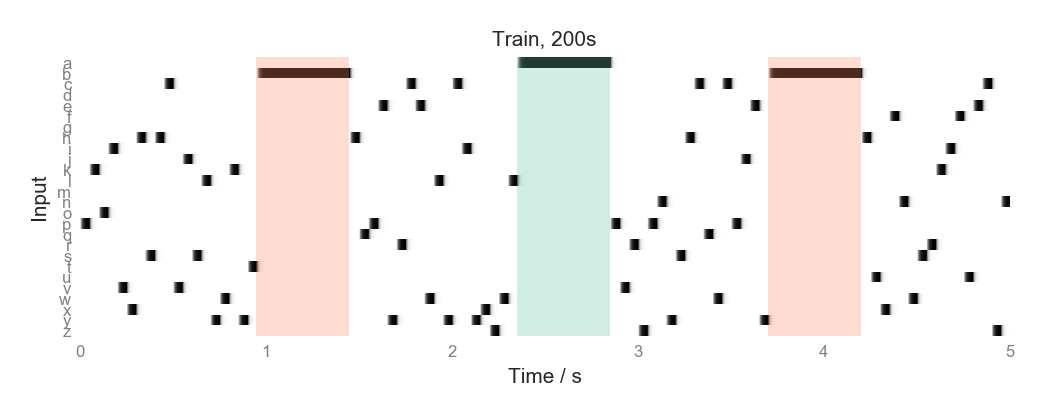

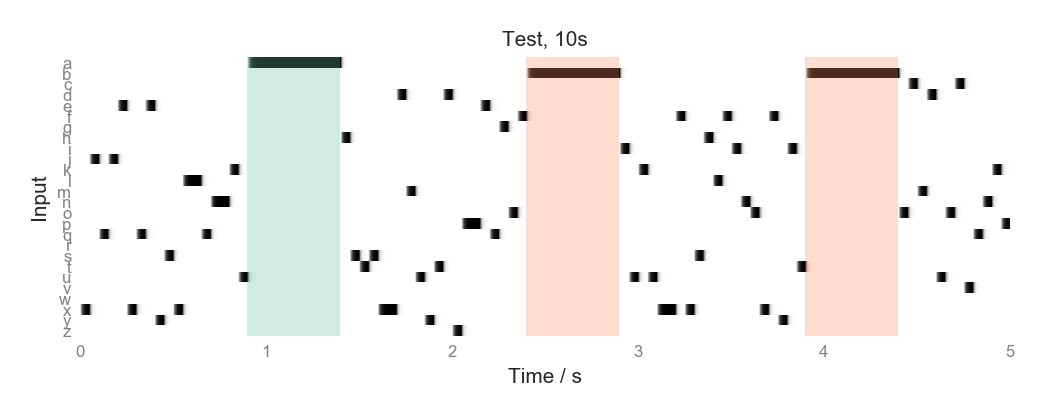

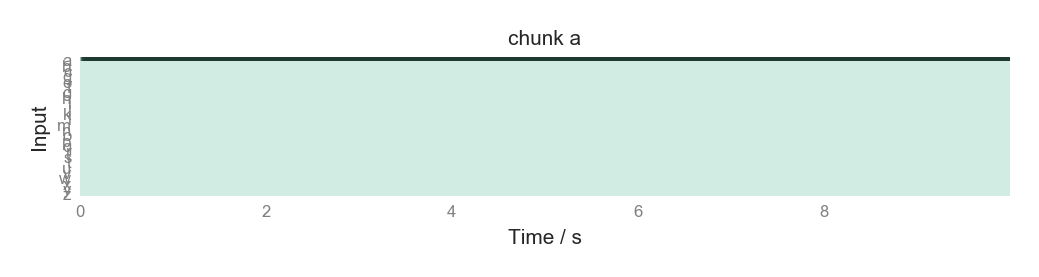

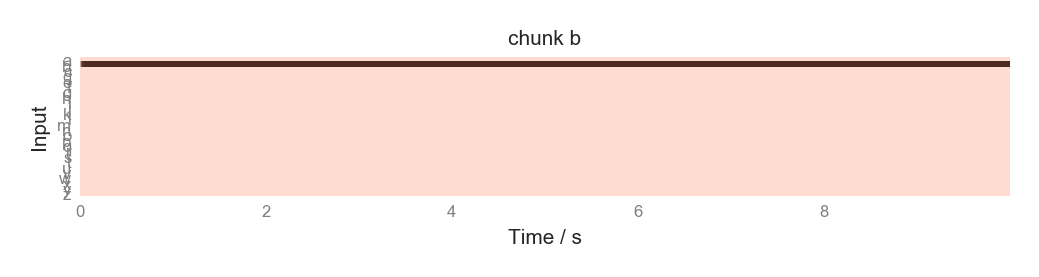

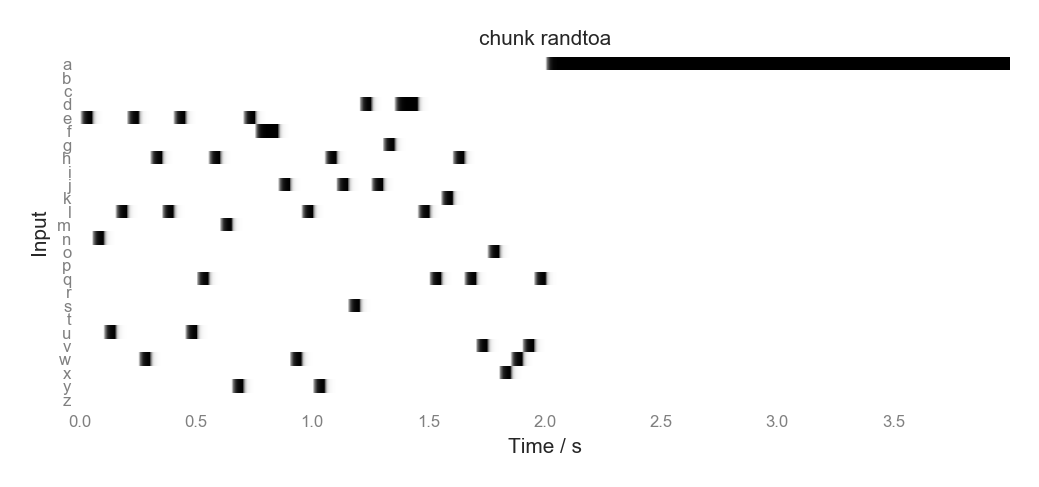

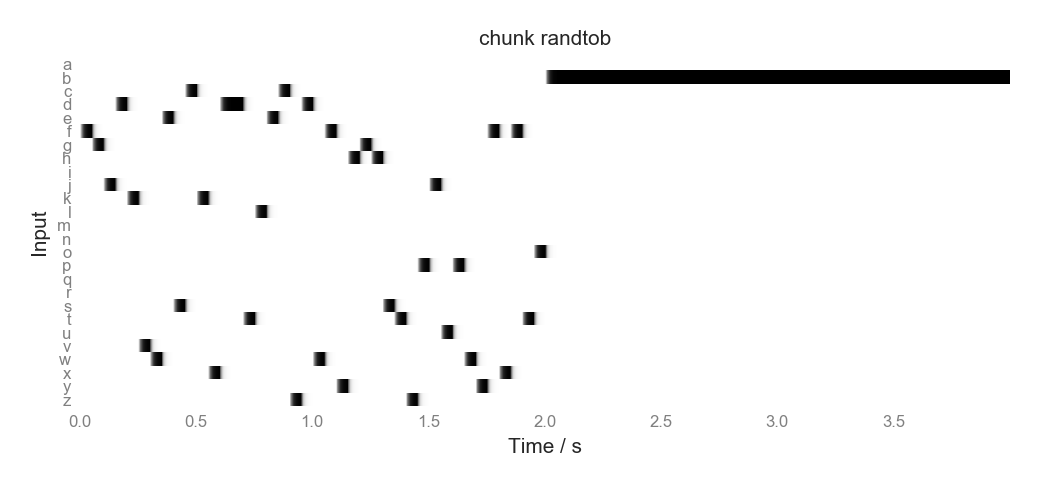

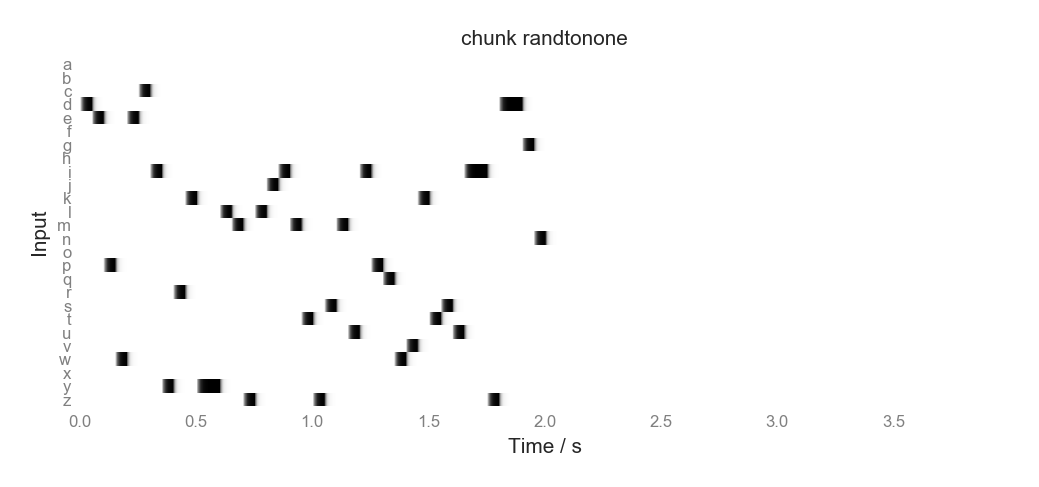

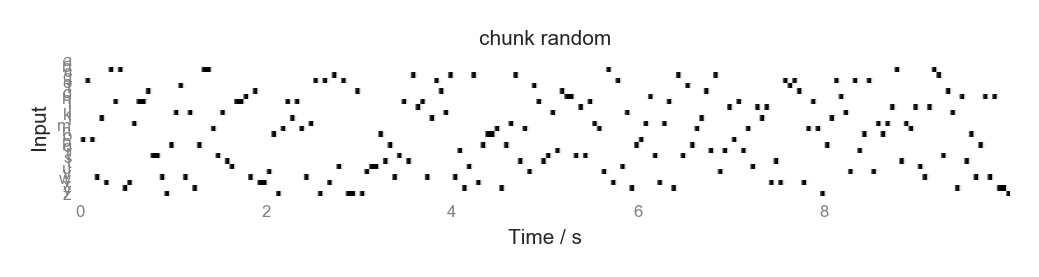

In [55]:
inputParams = defaultInputParams.copy()
inputParams['chunkList'] =[['a']*10,['b']*10]
inputParams['interChunkSyllables'] = alphabet[2:]
inputParams['gapRange'] = [15,20]
inputs = getInputs(inputParams,totalTime=200)
plotInputs(inputs,title='Train, 200s')

inputsTest = getInputs(inputParams,totalTime=10)
plotInputs(inputsTest,title='Test, 10s')

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['a']*200]
inputParams['chunkLabels'] = [0]
inputsTest_a = getInputs(inputParams)
plotInputs(inputsTest_a,title='chunk a',tstart=0,tend=10)

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['b']*200]
inputParams['chunkLabels'] = [1]
inputsTest_b = getInputs(inputParams)
plotInputs(inputsTest_b,title='chunk b',tstart=0,tend=10)

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['ab_']*40 + ['a']*40]
inputParams['chunkLabels'] = ['r']
inputsTest_ra = getInputs(inputParams)
plotInputs(inputsTest_ra,title='chunk randtoa')

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['ab_']*40 + ['b']*40]
inputParams['chunkLabels'] = ['r']
inputsTest_rb = getInputs(inputParams)
plotInputs(inputsTest_rb,title='chunk randtob')

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['ab_']*40 + [' ']*40]
inputParams['chunkLabels'] = ['r']
inputsTest_rn = getInputs(inputParams)
plotInputs(inputsTest_rn,title='chunk randtonone')

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['ab_']*200]
inputParams['chunkLabels'] = ['r']
inputsTest_r = getInputs(inputParams)
plotInputs(inputsTest_r,title='chunk random',tstart=0,tend=10)

In [4]:
hyperparams = defaultHyperparams.copy()
#hyperparams = {'Ng' : 200, #no. neurons in each reservoir 
#               'n' : 100, #no. reservoir neurons the output neuron is connected to 
##               'p' : 1, #connection probability amongst recurrent units
#               'tau' : 10, #neuron time constant, in ms 
#               'dt' : 1, #simulation timestep in ms
#               'g_GG' : 1.5, #RNN chaos parameters ( > 1 means chaos)
#               'g_Gz' : 1, #feedback strength,
#               'alpha' : 100, #learning rate
#               'sigma' : 0.3,#amount of network noise
#               'Nz' : 1, #no. of output neurons,
#               'ipr' : 3,
#               'Ni' : 26} #no. input neurons. Must be consistent with ther inputs passed 
hyperparams['Nin'] = inputs['data'].shape[1]

In [5]:
reservoirPair = ReservoirPair(hyperparams,inputs)
reservoirPair.storeInputs(inputsTest,name='test')
reservoirPair.trainPair()
reservoirPair.testPair(testName='posttraining',testData='test',Ntest=5,returnItems=['z','r'])

Training reservoir pair:   0%|          | 0/200000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
pickleAndSave(reservoirPair,'lyapunov')

In [6]:
reservoirPair = loadAndDepickle('lyapunov')

(<Figure size 1200x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd2505951d0>)

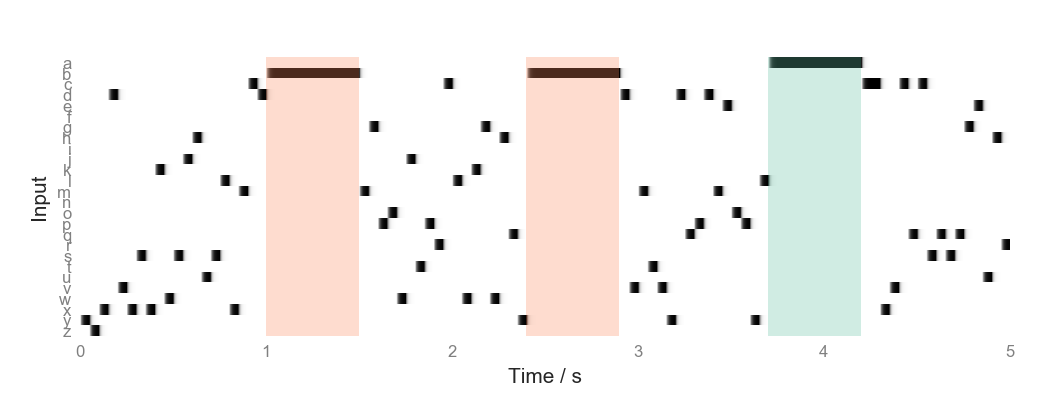

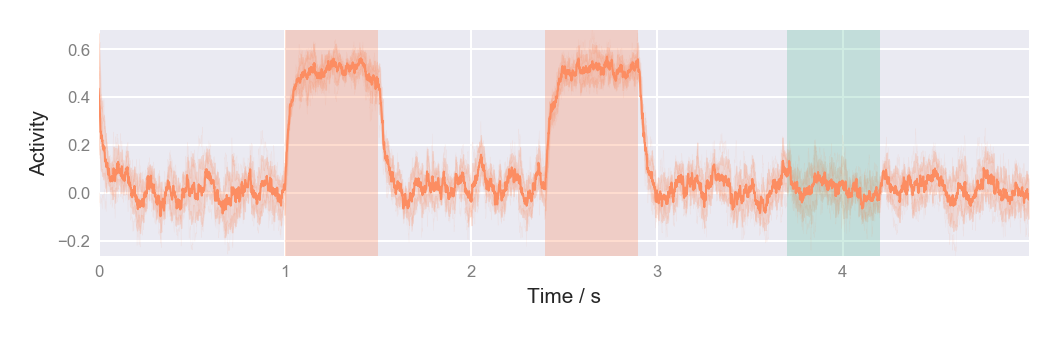

In [7]:
plotInputs(reservoirPair.inputDict['test'])
plotTest(reservoirPair,testName='posttraining',testData='test')

### Find the lyapunov exponent for a standard reservoir net 

Testing different g values:   0%|          | 0/2 [00:00<?, ?it/s]

Performing 5 repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5 repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'Perturbation size: $\\frac{ \\Vert \\vec{\\mathbf{x}}(t) - \\vec{\\mathbf{x}}_{ref}(t) \\Vert }{ \\langle \\Vert  \\vec{\\mathbf{x}}_{ref}(0)  \\Vert \\rangle }$')

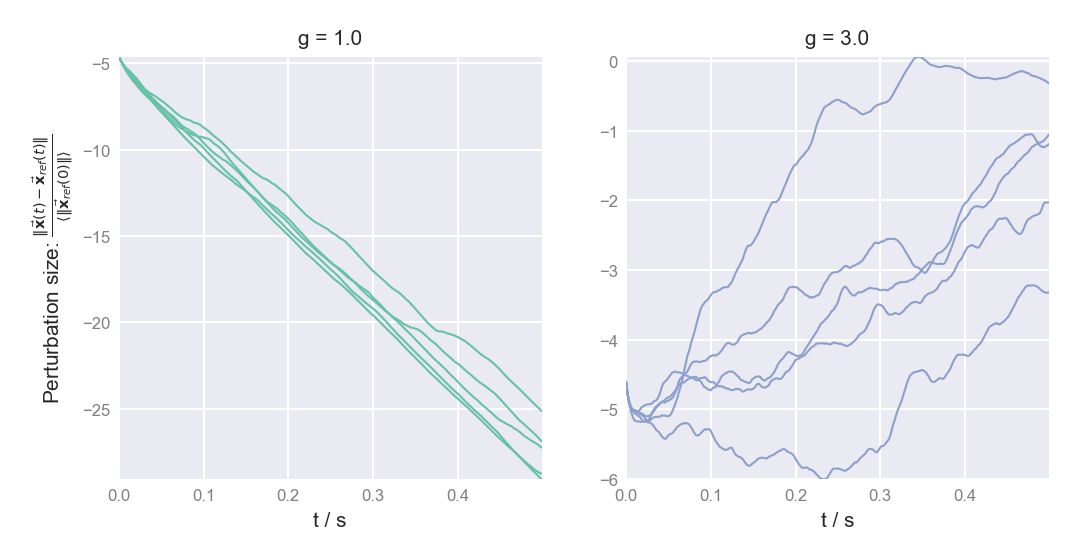

In [41]:
hyperparams = defaultHyperparams.copy()
hyperparams['sigma'] = 0.3
inputStrength = 1
noiseStrength = 1
feedbackStrength = 1

colorList = ['C0','C2','C1']

g_range = [1,3]
fig,ax = plt.subplots(1,len(g_range),figsize=(2*len(g_range),2))

steps = 500
nTests = 5
n_g = len(g_range)
t = np.arange(steps+1)*hyperparams['dt']

hyperparams['dt'] = 1
hyperparams['sigma'] *= noiseStrength

animationX = np.zeros(shape=(n_g,steps,nTests,2))
                    
for (i,g) in enumerate(tqdm(g_range,desc="Testing different g values")):
    plotDeviation = np.zeros(shape=(nTests,steps))
    np.random.seed()
    #INITIALISE REFERENSE RESERVOIR AND SPIN IT UP 
    hyperparams['g_res'] = g

    refRes = Reservoir(hyperparams)
    refRes.J_Gz *= feedbackStrength  #feedback
    refRes.J_GI *= inputStrength #inputs (uniform)

    xav = np.linalg.norm(refRes.x)
    for j in range(1000): #1 seconds spin up
        x = np.linalg.norm(refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']),returnItems=['x'])['x'])
        xav = xav + (1/(j+1))*(x - xav)

    copy_xs = np.zeros(shape=(len(g_range),steps,nTests,2))
    for n in tqdm(range(nTests),leave=False,desc='Performing %g repeats' %nTests):
        np.random.seed()
        refRes = Reservoir(hyperparams)
        refRes.J_Gz *= feedbackStrength  #feedback
        refRes.J_GI *= inputStrength #inputs (uniform)
        for j in range(1000): #1 seconds spin up
            refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']))
        copyRes = copy.deepcopy(refRes)
        perturbation = np.random.randn(refRes.Nres)
        perturbation /= np.linalg.norm(perturbation)
        perturbation *= 0.01*xav #random perturbation 10% size of x 
        copyRes.x += perturbation
        
        for s in range(steps):
            animationX[i,s,n,:] = copyRes.x[:2] - refRes.x[:2]
            plotDeviation[n,s] = np.linalg.norm(copyRes.x - refRes.x)
            np.random.seed(s)
            refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']))
            np.random.seed(s)
            copyRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']))
 
        ax[i].plot(np.arange(steps)*hyperparams['dt']/1000,np.log(plotDeviation[n]/xav),c=colorList[i])
    ax[i].set_xlabel("t / s")
    ax[i].set_title("g = %.1f" %g)
    ax[i].set_aspect((ax[i].get_xlim()[1]-ax[i].get_xlim()[0])/(ax[i].get_ylim()[1]-ax[i].get_ylim()[0]))
        
ax[0].set_ylabel(r"Perturbation size: $\frac{ \Vert \vec{\mathbf{x}}(t) - \vec{\mathbf{x}}_{ref}(t) \Vert }{ \langle \Vert  \vec{\mathbf{x}}_{ref}(0)  \Vert \rangle }$")    

In [76]:
saveFigure(fig,"chaosdeviation")

In [22]:
i = 2
fps = 10
length = 15 #s
writer = anim.FFMpegWriter(fps=fps,bitrate=4000) 
a = AnimatedChaos(data=animationX[i],fps=fps,length=length,xylim=5,color=colorList[i])
a.ani.save('./figures/chaosg20.mp4', writer=writer,dpi=300)

In [23]:
Video("./figures/chaosg20.mp4")

## Test variance over a chunk boundary

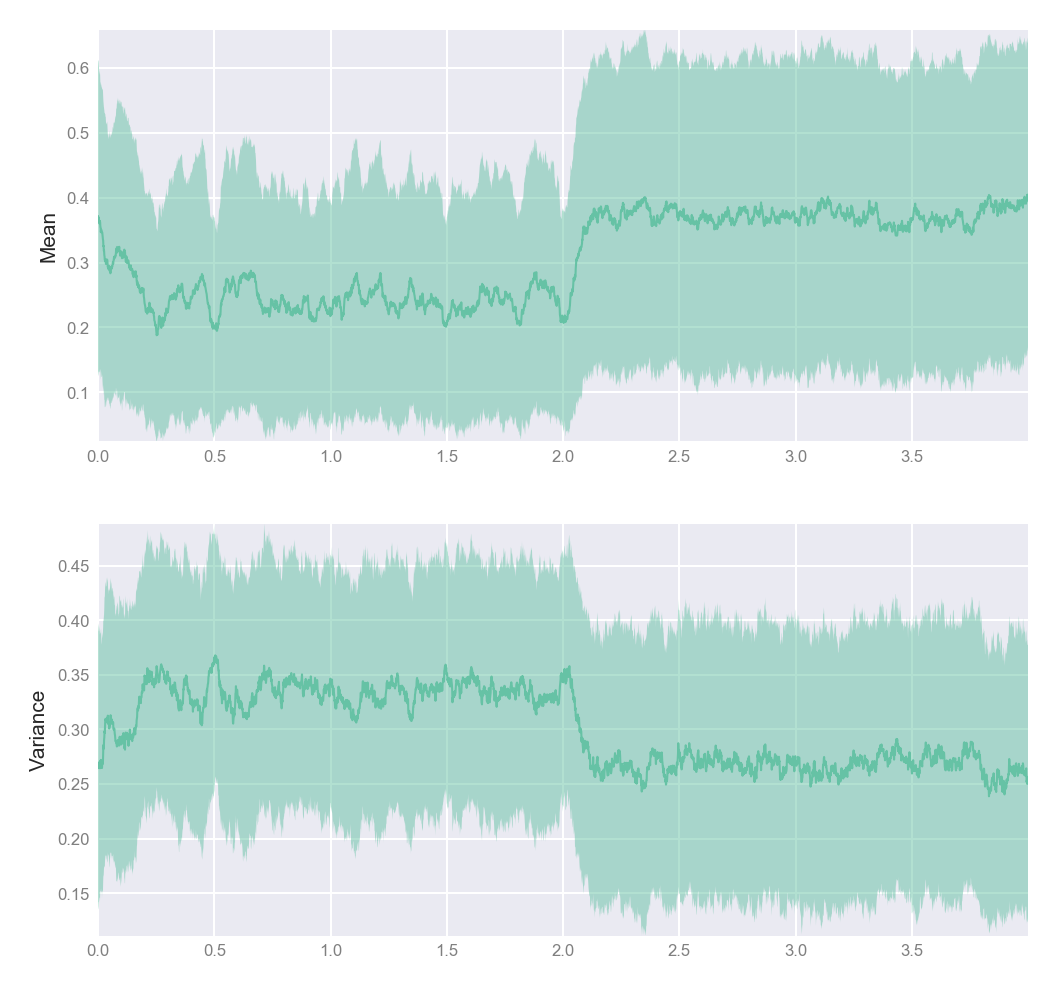

In [81]:
def testVarianceOverChunk(reservoir,chunk,ntest=10):
    nodeData = np.zeros(shape=(ntest,chunk['data'].shape[0],reservoir.Nres))
    for n in range(ntest):
        for t in range(chunk['data'].shape[0]):
            nodeData[n,t,:] = reservoir.runDynamicsStep(inputVec=chunk['data'],returnItems=['r'])['r']
    
    varOverTrials = np.var(nodeData,axis=0)
    meanOverTrials = np.abs(np.mean(nodeData,axis=0))
    
    meanOfVar = np.mean(varOverTrials,axis=1)
    stdOfVar = np.std(varOverTrials,axis=1)
    meanOfMean = np.mean(meanOverTrials,axis=1)
    stdOfMean = np.std(meanOverTrials,axis=1)
    
    fix, ax = plt.subplots(2,1,figsize=(4,4))
    ax[0].plot(chunk['t'],meanOfMean)
    ax[0].fill_between(chunk['t'],meanOfMean+stdOfMean,meanOfMean-stdOfMean,alpha=0.5)
    ax[0].set_ylabel("Mean")
    
    ax[1].plot(chunk['t'],meanOfVar)
    ax[1].fill_between(chunk['t'],meanOfVar+stdOfVar,meanOfVar-stdOfVar,alpha=0.5)
    ax[1].set_ylabel("Variance")

    return fig, ax




#testVarianceOverChunk(reservoirPair.res1,inputsTest_rn)
#testVarianceOverChunk(reservoirPair.res1,inputsTest_r)
testVarianceOverChunk(reservoirPair.res1,inputsTest_ra)
testVarianceOverChunk(reservoirPair.res1,inputsTest_rb)


        
        

## Test Lyapunov component in chunk

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

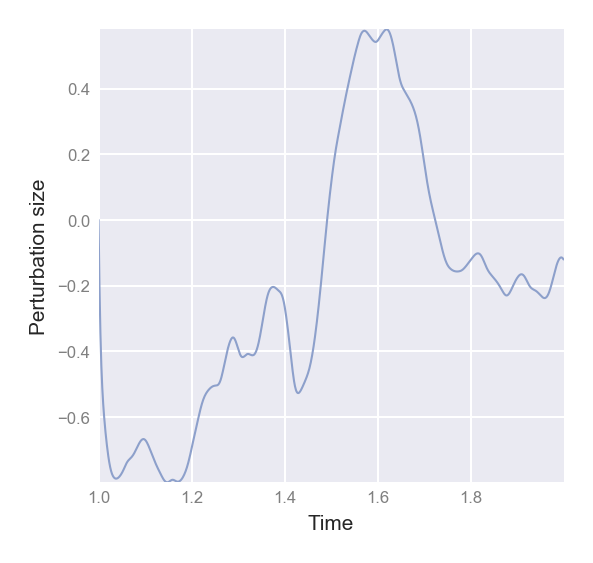

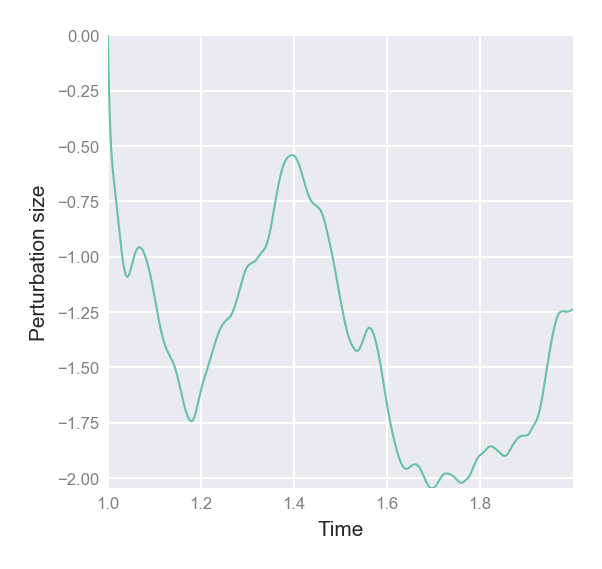

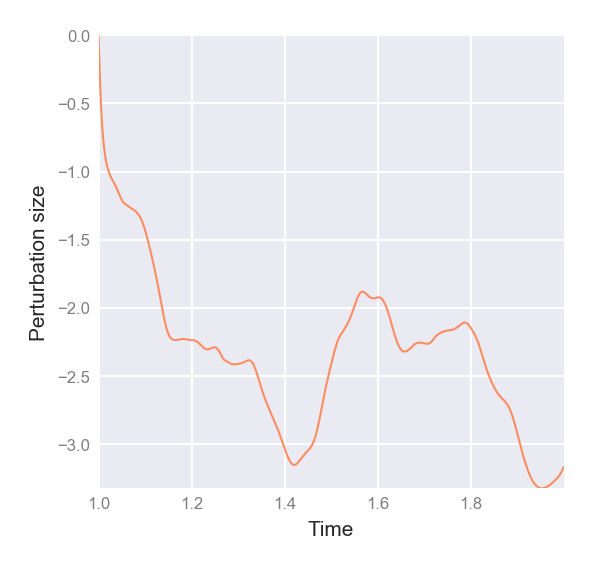

In [62]:
def getLyapunovExponent(reservoir, chunk, tstart, ncopies=10, tperturbation=1,color='C0'):
    startPertId = np.argmin(np.abs(chunk['t'] - tstart))
    #spin up 
    fig, ax = plt.subplots(figsize=(2,2))
    xav = 0
    for t_id in range(startPertId):
        x = reservoir.runDynamicsStep(inputVec=chunk['data'][t_id],returnItems=['x'])['x']
        xav = xav + (1/(t_id+1))*(np.linalg.norm(x) - xav)

    stopPertId = np.argmin(np.abs(chunk['t'] - (chunk['t'][startPertId] + tperturbation)))
    tPerturbation = chunk['t'][startPertId:stopPertId]

    for n in tqdm(range(ncopies)):
        #make copies
        pert_res = copy.deepcopy(reservoir) #reservoir to be perturbed 
        ref_res = copy.deepcopy(reservoir) #reference reservoir 
        #perturb one of them
        perturbation = np.random.randn(ref_res.Nres)
        perturbation /= np.linalg.norm(perturbation)
        perturbation *= 0.01*xav #random perturbation 10% size of x 
        pert_res.x += perturbation
        x_pert_0, x_pert = pert_res.x, pert_res.x
        x_ref_0, x_ref = ref_res.x, ref_res.x
        pert_size = np.linalg.norm(x_ref - x_pert) / np.linalg.norm(x_ref_0 - x_pert_0)
        #run dynamics
        pert_size_array = [] 
        for t_id in range(startPertId,stopPertId):
            pert_size_array.append(pert_size)
            x_pert = pert_res.runDynamicsStep(inputVec = chunk['data'][t_id], returnItems=['x'])['x']
            x_ref = ref_res.runDynamicsStep(inputVec = chunk['data'][t_id], returnItems=['x'])['x']
            pert_size = np.linalg.norm(x_ref - x_pert) / np.linalg.norm(x_ref_0 - x_pert_0)
        ax.plot(tPerturbation,np.log(pert_size_array),c=color)
        ax.set_xlabel("Time")
        ax.set_ylabel("Perturbation size")

        return 

getLyapunovExponent(reservoirPair.res1,inputsTest_r,tstart=1,tperturbation=1,ncopies=5,color='C2')
getLyapunovExponent(reservoirPair.res1,inputsTest_ra,tstart=1,tperturbation=1,ncopies=5,color='C0')
getLyapunovExponent(reservoirPair.res1,inputsTest_rb,tstart=1,tperturbation=1,ncopies=5,color='C1')